In [279]:
import matplotlib.pylab as plt
import numpy as np
from scipy.optimize import curve_fit 
import glob
import os

plt.style.use(['seaborn-v0_8-dark', 'science'])
glob.glob('logging/*')

%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 200

In [280]:
def model(x, a, x0, s, C):
    return a/np.sqrt(2*np.pi)/s*np.exp(-1/2*(x-x0)**2/s**2) + C

In [290]:
# uncalibrated files
files = sorted(glob.glob('logging/1_39/[0-9]*.csv'))[20:-20]


pos_mm = np.array([float(".".join(os.path.basename(f).split('_')[:2])) for f in files])
e_pos = 100e-6
V = np.array([np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',').mean(axis = 0)[-1] for f in files])

e_V = np.array([np.genfromtxt(f, skip_header= 8, dtype = float, 
                        delimiter = ',').std(axis = 0)[-1] for f in files])



In [291]:
# plt.errorbar(pos_mm, V, xerr = e_pos, yerr= e_V ,fmt = 'ko', ms = .1)
xx = np.linspace(np.min(pos_mm), np.max(pos_mm), 200)
# plt.plot(xx, model(xx, .05, 22.659,.008, .5))

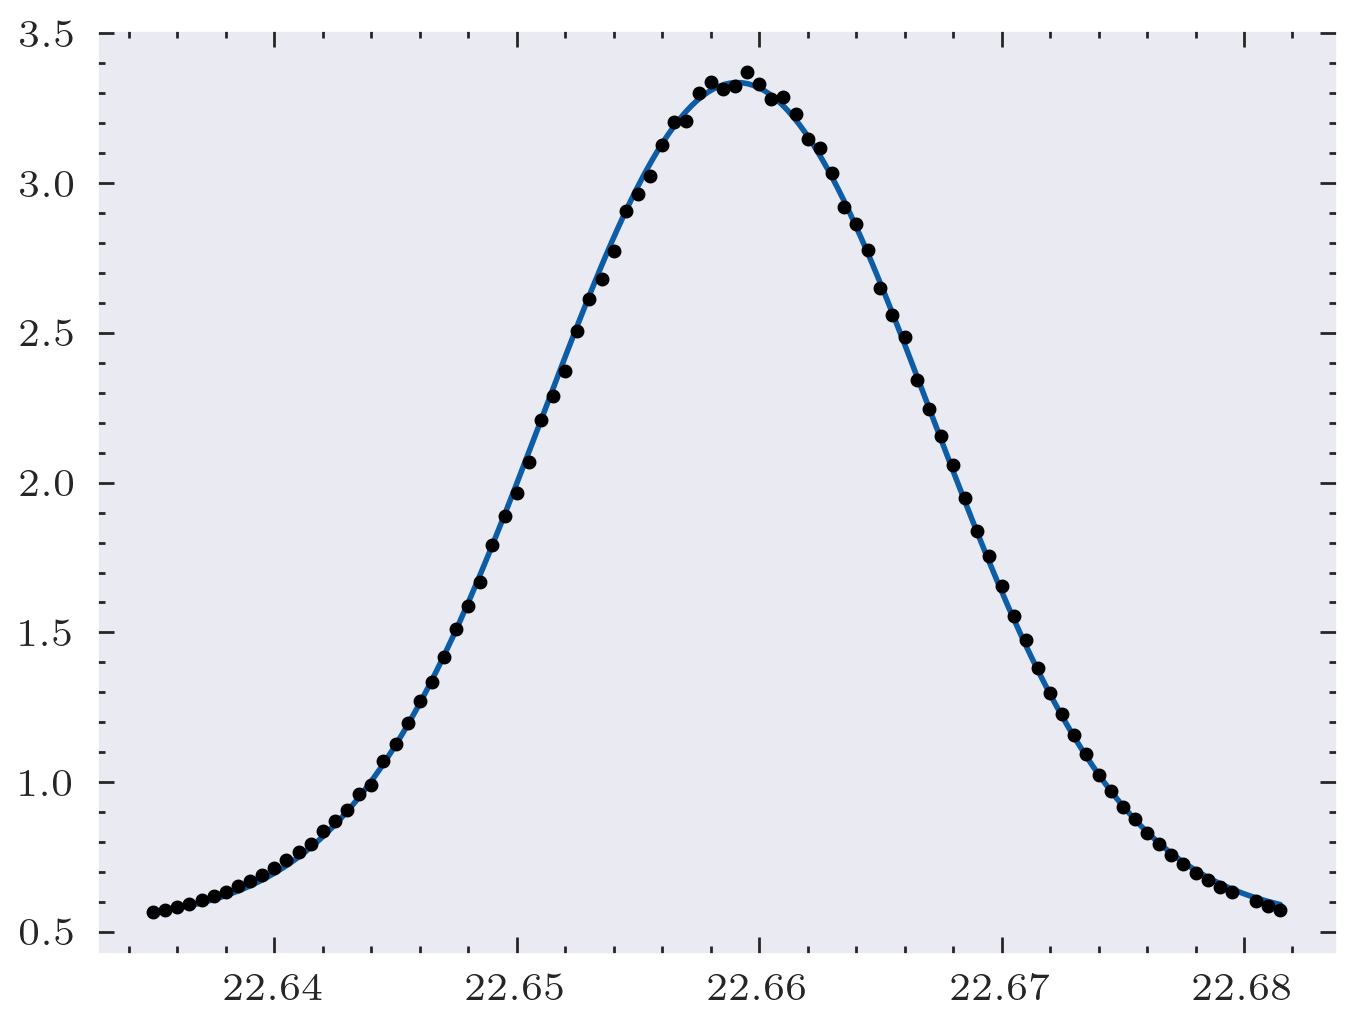

In [292]:
fit, err = curve_fit(model, pos_mm, V, sigma = e_V, absolute_sigma= True,  p0 = [.05, 22.659,.008, .5])
plt.plot(xx, model(xx, *fit))
plt.plot(pos_mm, V,'ko', ms = 1.5)
# plt.text(f'{fit}')

**We measured in delay distance. The time delay is distance change times two. But the signal is twice as wide, in time domain, as the original signal by symmetry!!**

In [293]:
width = fit[-2]/1e3/3e8 /1e-15 * 2 / 2
e_width = np.sqrt(np.diag(err))[-2]/1e3/3e8 /1e-15
print(f'{width:.3f} +/- {e_width:.3f}')

26.588 +/- 0.008


In [294]:
t_fs = (pos_mm - fit[-3])/1e3/2.998e8/1e-15*2
e_t_fs = np.sqrt((e_pos/1e3/2.998e8/1e-15*2)**2 + (np.sqrt(np.diag(err))[-3]/1e3/2.998e8/1e-15*2)**2)

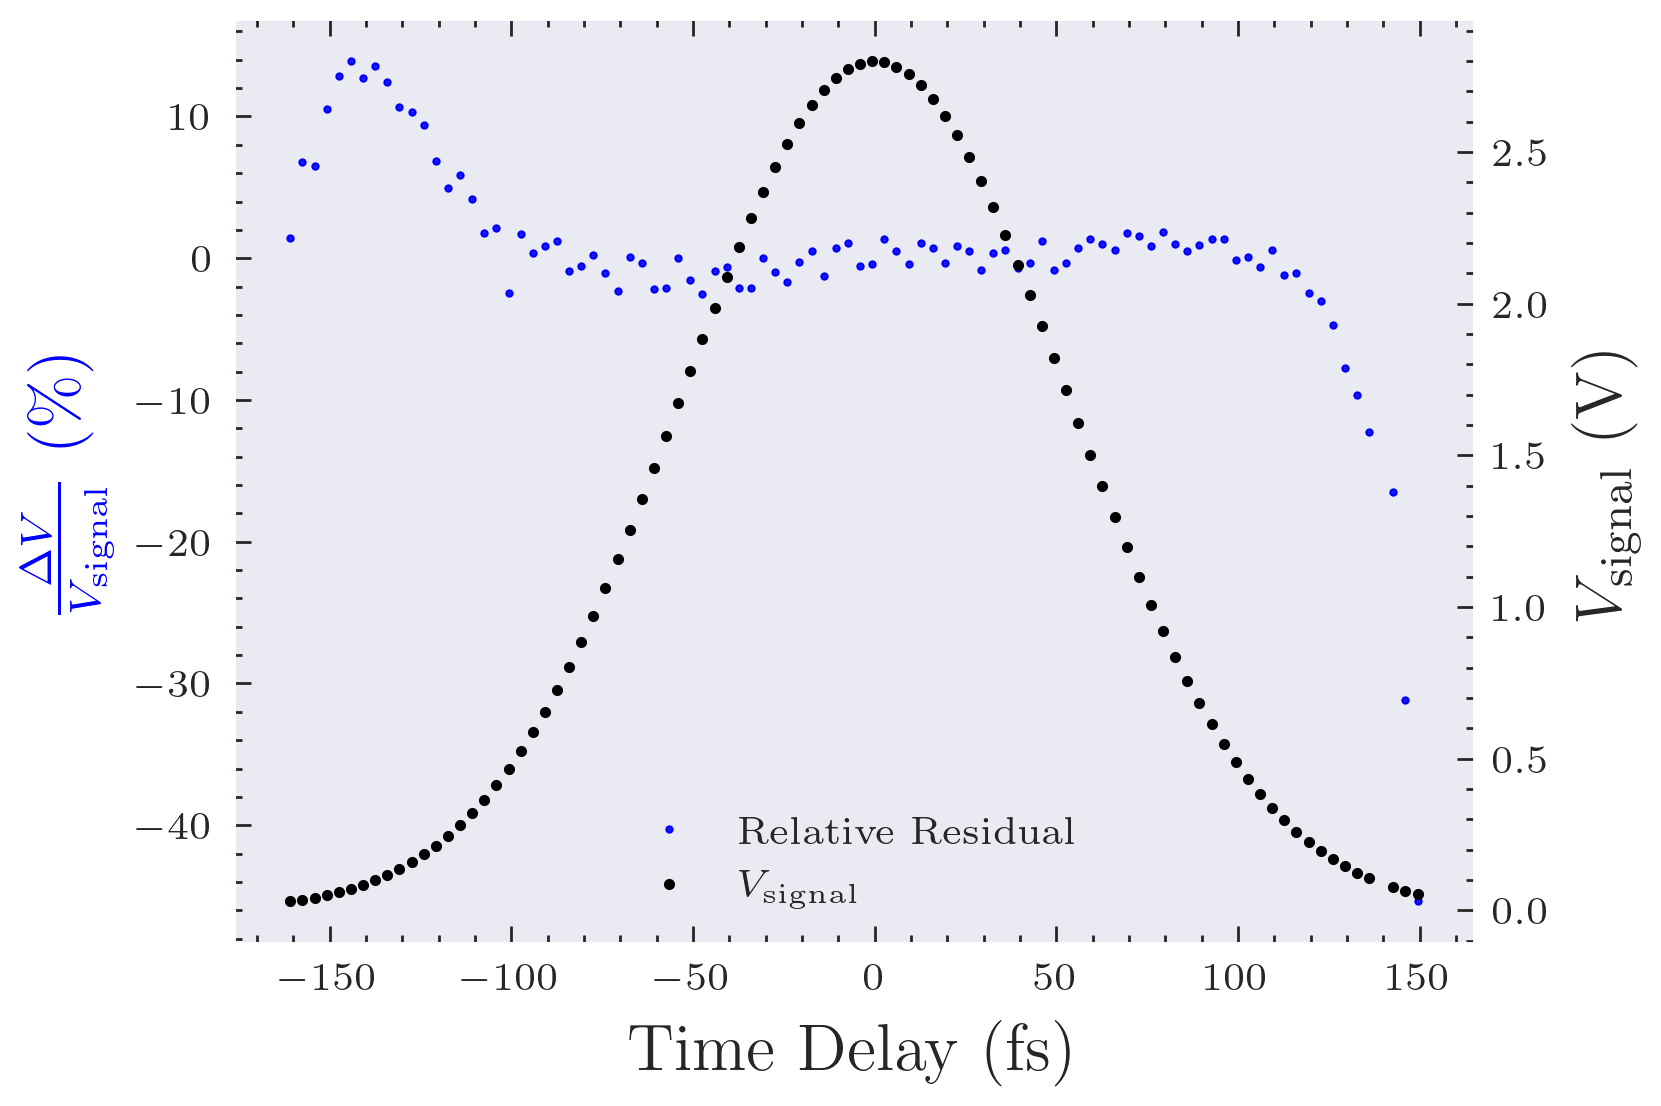

In [295]:
signal = model(pos_mm, *fit[:-1], 0)

ax1 = plt.gca()
line_1 = ax1.plot(t_fs, (V - model(pos_mm, *fit)) / (V- fit[-1]) *100,'b.', label = 'Relative Residual',
                 zorder = -2, ms = 1)

ax1.set_ylabel(r'$\frac{\Delta V}{V_{\mathrm{signal}}}$ (\%)', color = 'b')
# ax1.set_yscale('log')
ax2 = ax1.twinx()


line_2 = ax2.plot(t_fs, signal, ls = 'None', c= 'k', marker= '.', ms = 2
                     , zorder = -2,
                    label ='$V_{\mathrm{signal}}$ ')
ax2.set_ylabel('$V_{\mathrm{signal}}$ (V)')

lines = [line_1[0],line_2[0]]
labs = [l.get_label() for l in lines]

ax1.set_xlabel('Time Delay (fs)')
plt.legend(lines, labs, loc= 8)




We see this asymmetry due to imperfect alignment. But this is good enough?

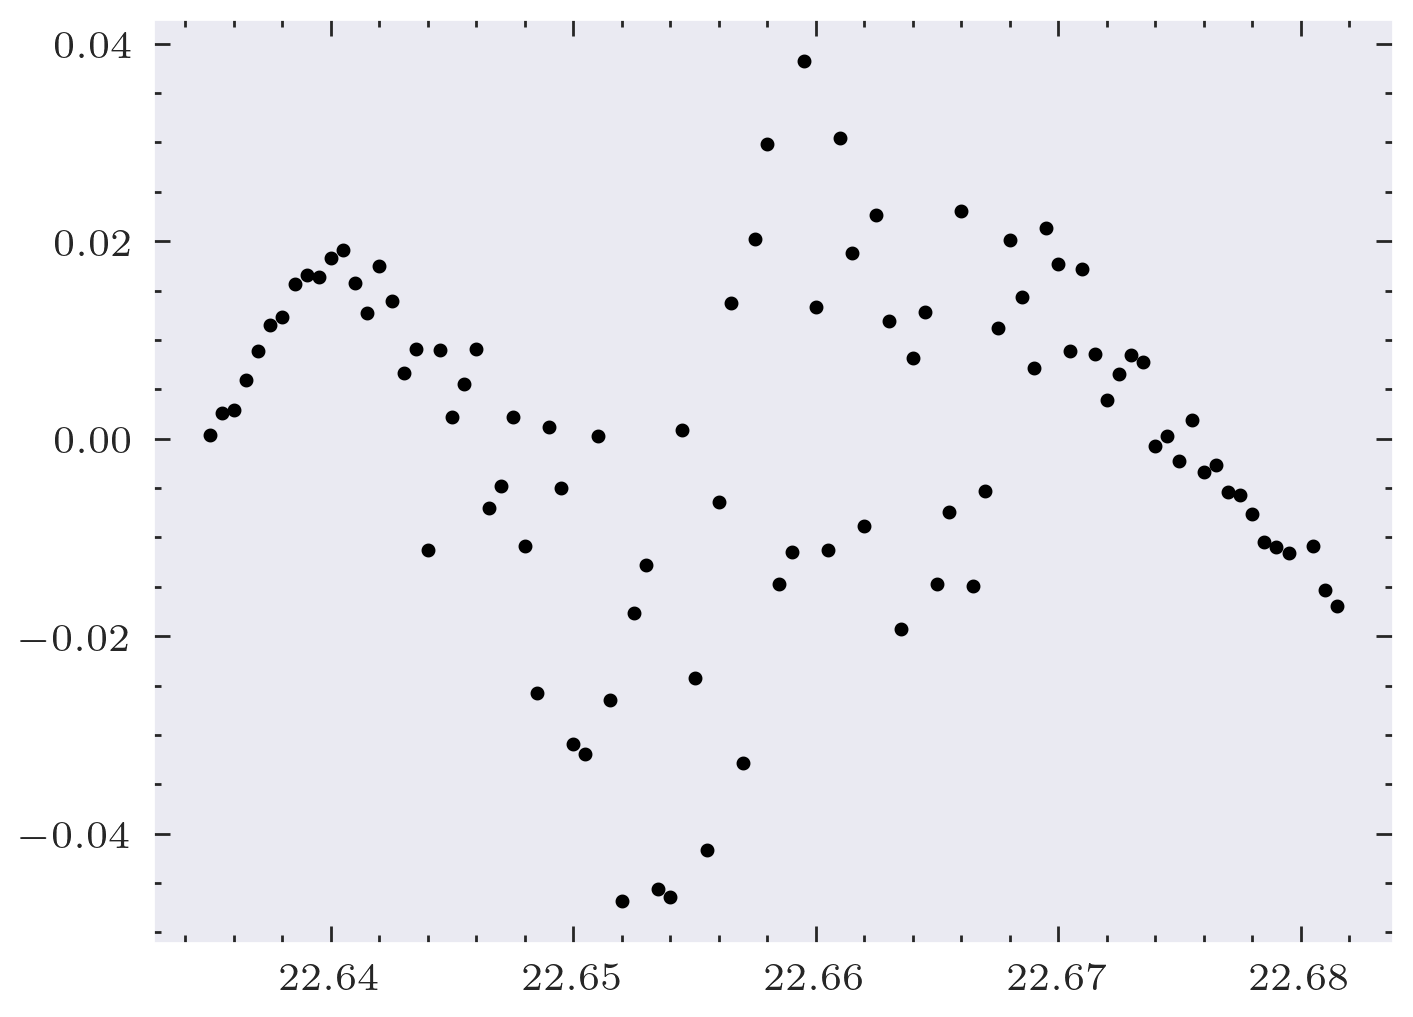

In [299]:
# plt.plot(xx, model(xx, *fit))
# plt.plot(pos_mm, V,'ko', ms = 1.5)
plt.plot(pos_mm, V - model(pos_mm, *fit), 'k.')

In [297]:
V[np.argmin(np.abs(pos_mm-22.652))]

2.3734061255012224

In [298]:
pos_mm[np.argmin(np.abs(pos_mm-22.652))]

22.652